In [1]:
import numpy as np
import matplotlib.pyplot as plt

from reeb_graph_simulation import Reeb_Graph
from reeb_aux import *

from utils import *

In [2]:
np.random.seed(17051991)

 # Classical Max-Flow vs Circular Max-Flow
 
 In this simulation we show that circular maxflow is much more suited for dealing with geometric structures with periodic boundary conditions, compared to classical max-flow.
 
 To do so, we sample points according to an inhomogeneous Poissoin process which concentrates points close to the segment [p,q] which is plotted in red in the following. We then impose periodic boundary conditions and compute source targer max-flow for the sampled point cloud and the point cloud translated vertically by half the size of the window. With the source being the bottom of the window and the target the top.
 
 Our results show that, in this scenario - which is very much alike simulations in materials science, with periodic boundary conditions - source target max-flow varies greatly upon translating the point cloud upwards. 
 
Which implies that source target max-flow is clearly inadequate to handle periodic boundary conditions, unlike circular max-flow which does not rely on having to choose a source and a target.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


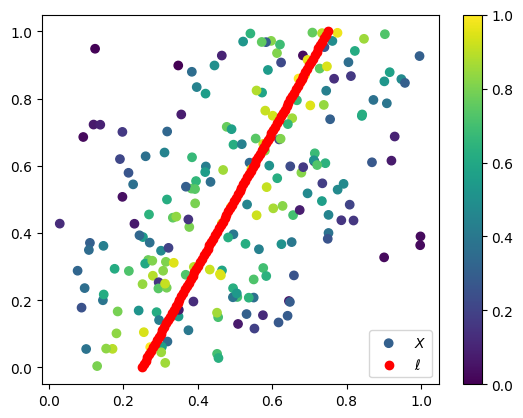

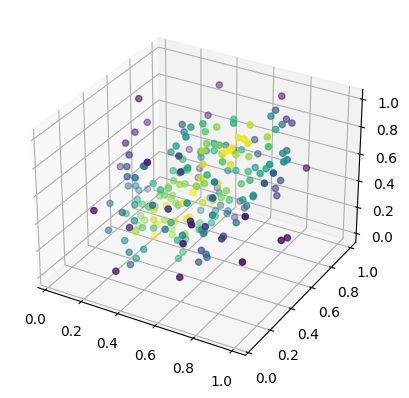

In [3]:
# Example of an inhomogeneus Poisson process, with highlighted the high density segment

p = np.array([0.25,0.5,0])
q = np.array([0.75,0.5,1])
n = 100
sigma = 0.2
lam=800

X = inhom_poisson(p, q, lam=lam, n=n,sigma=sigma,dim=3)
DENS = [dens_eval(x,p, q, n=n,sigma=sigma,dim=3) for x in X]
aux = max_density(p, q, n=n, sigma=sigma,dim=3)

L = make_line(p,q,n=n,dim=3)

plt.scatter(X[:,0],X[:,2],c=DENS, label='$X$')
plt.scatter(L[:,0],L[:,2],c='r', label='$\ell$')
plt.colorbar()
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2],c=DENS)

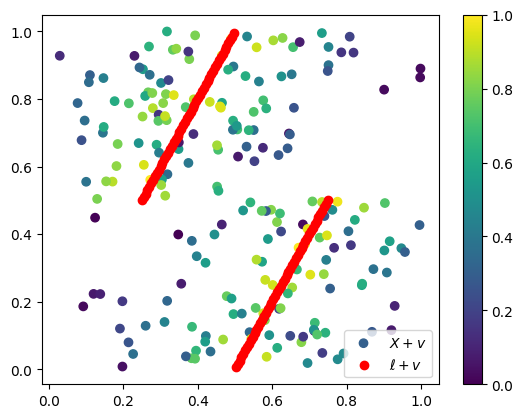

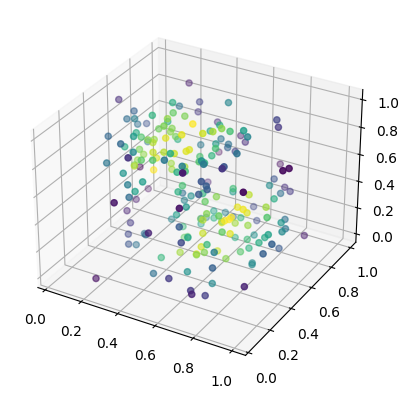

In [4]:
# The same poit cloud as in the previous cell, but translated upwards with periodic boundary conditions

v = np.array([0,0,0.5])
M = np.array([1,1,1],dtype=float)
m = np.array([0,0,0],dtype=float)

X_aux = X+v
X_aux = m + np.remainder(X_aux-m, M-m)

L_aux = L+v
L_aux = m + np.remainder(L_aux-m, M-m)


plt.scatter(X_aux[:,0],X_aux[:,2],c=DENS, label='$X+v$')
plt.scatter(L_aux[:,0],L_aux[:,2],c='r', label='$\ell+v$')
plt.colorbar()
plt.legend()
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_aux[:,0],X_aux[:,1],X_aux[:,2],c=DENS)

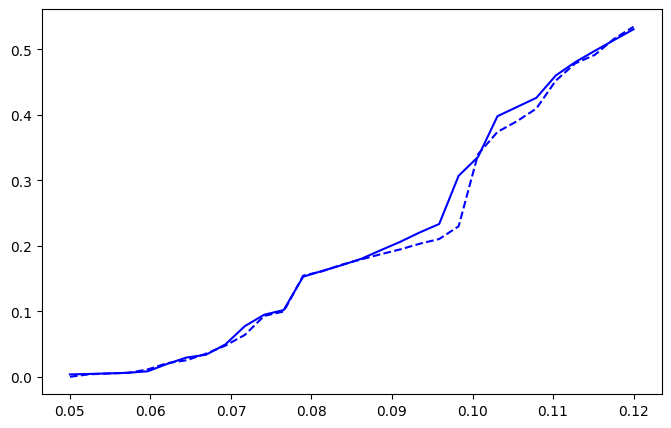

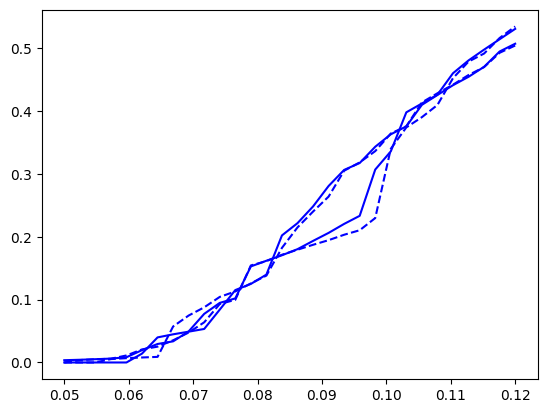

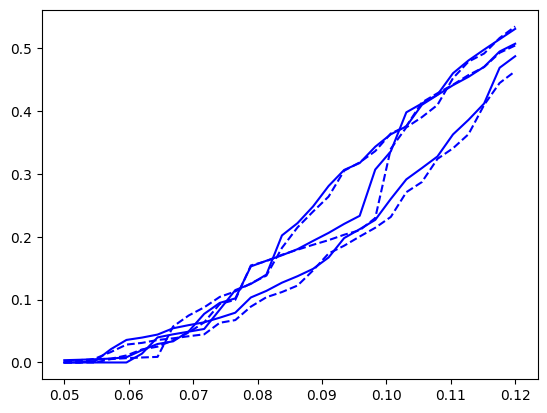

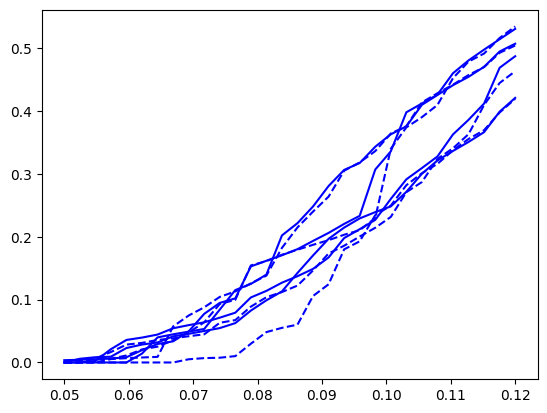

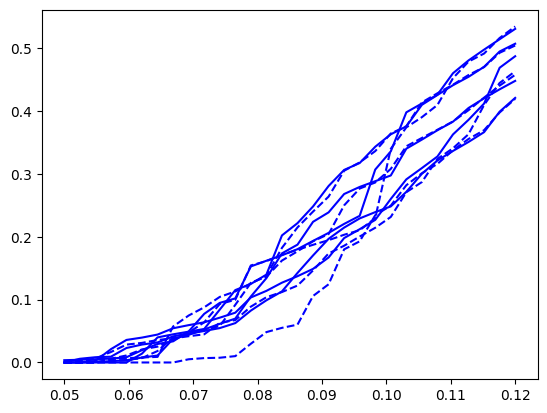

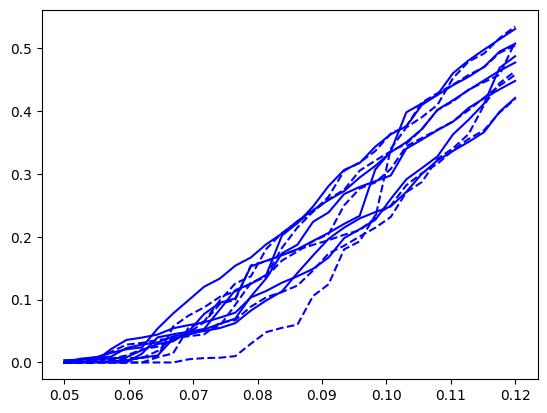

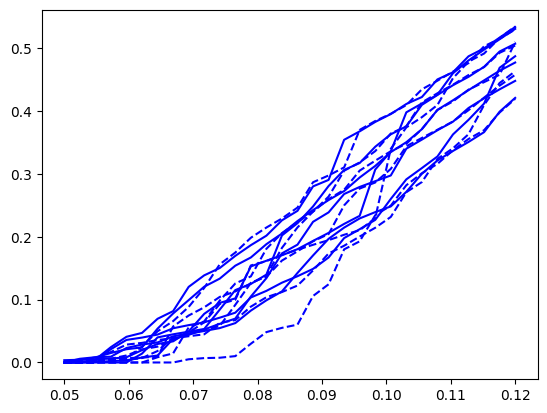

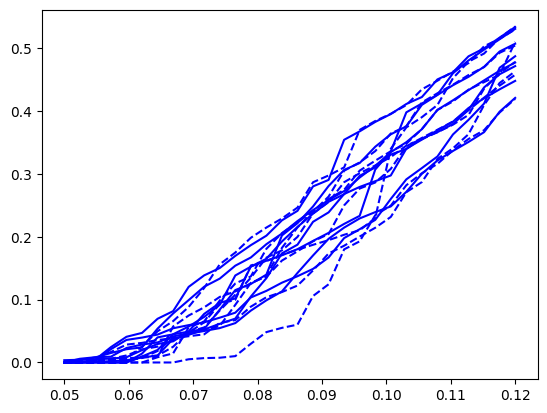

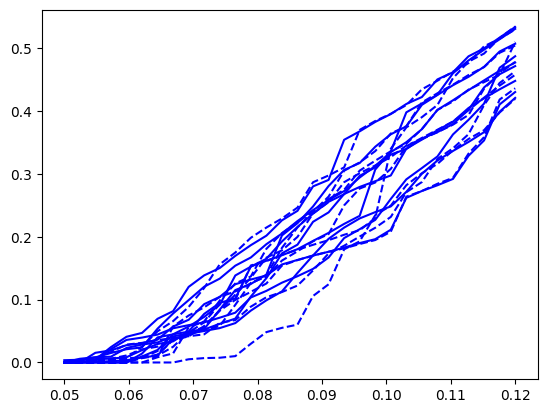

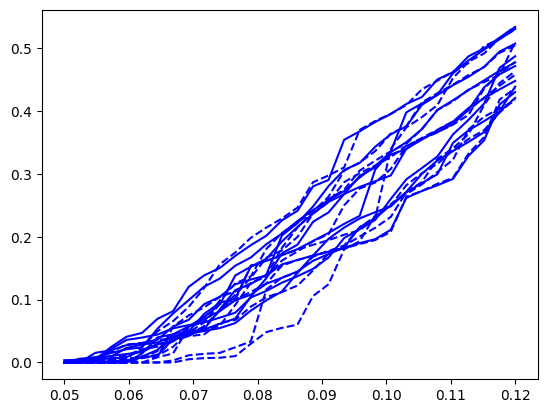

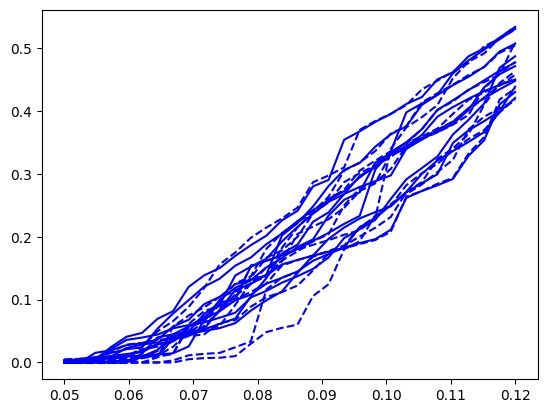

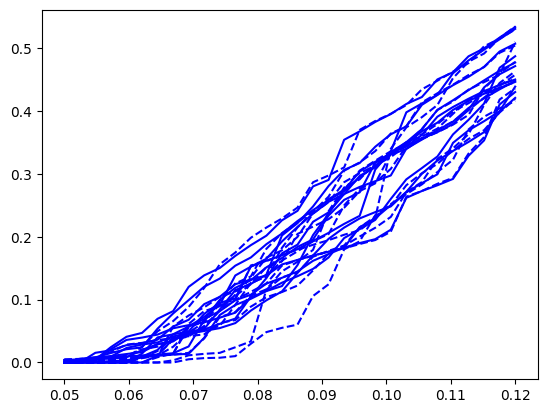

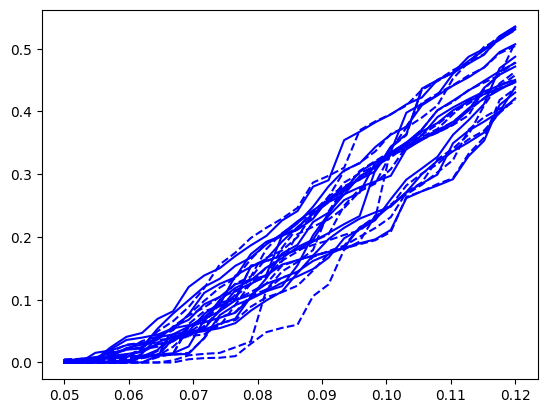

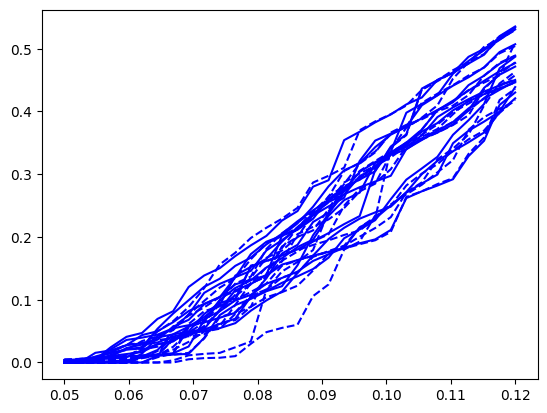

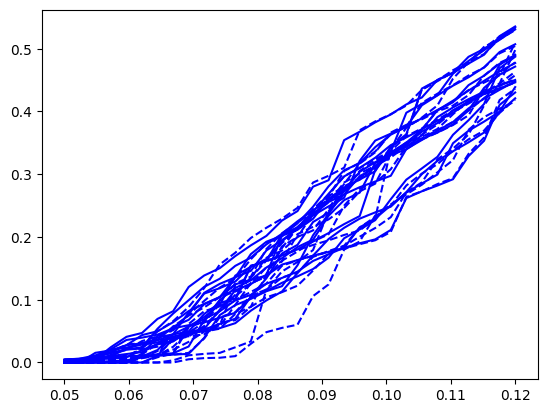

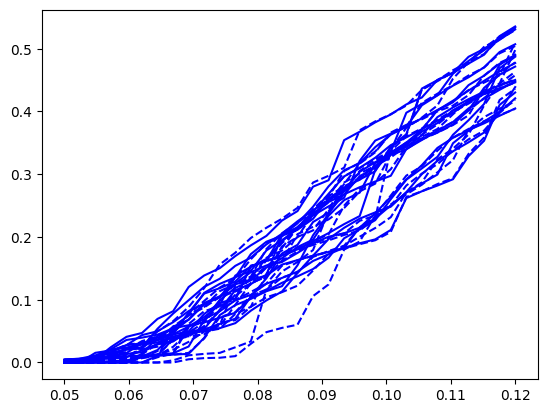

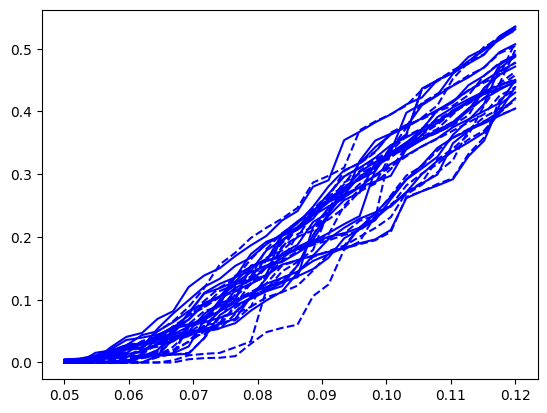

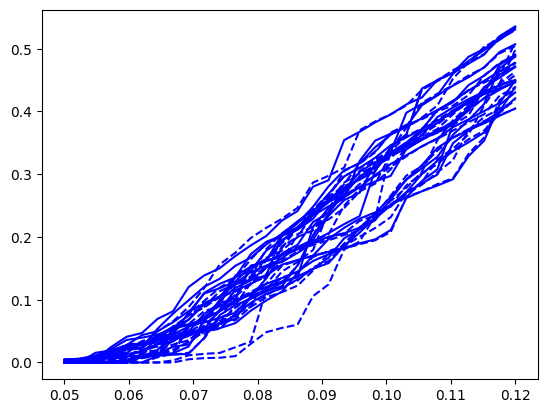

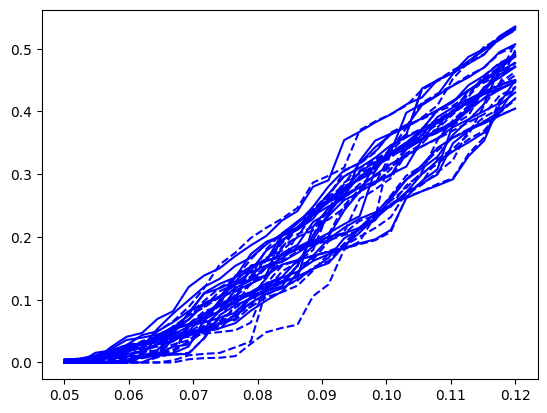

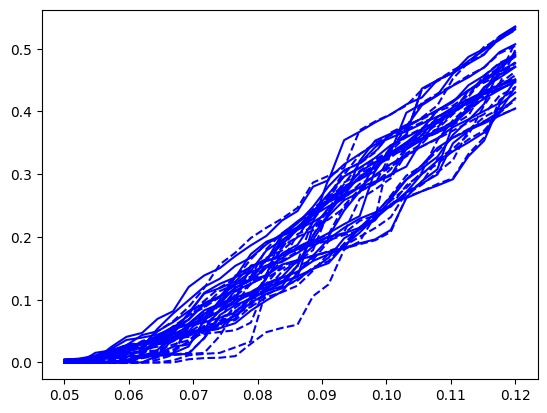

In [5]:
n_grid = 101
fat = 1
covering = np.array([-1,1])
reeb_stride = 2
relax = [n_grid//2,-(n_grid//2+1)]
stride = 20


F = []
G = []
R = []

colors = ['b','r','g']
r_grid = np.linspace(0.05,0.12,30)


plt.ion()
figure, ax = plt.subplots(figsize=(8, 5))
    
plt.isinteractive()

c = []

for count in range(20):

        p = np.array([0.25,0.5,0])
        q = np.array([0.75,0.5,1])
        n = 100
        sigma = 0.2
        lam=800

        X_ = inhom_poisson(p, q, lam=lam, n=n,sigma=sigma,dim=3)
        
        v = np.array([0,0,0.5])
        X_aux = X_+v
        X_aux = m + np.remainder(X_aux-m, M-m)

        f = []
        g = []
        r_aux = []
        radii = np.ones_like(X_[:,0])
        
        tmp =[f,g]
        
        for i,X in enumerate([X_,X_aux]):
        
            for j,k in enumerate(r_grid):

                r = radii*k 

                reeb = Reeb_Graph(X, M = M, m = m, radii = r,
                    grid_size = n_grid, 
                    periodic = True,
                    fat_radius = fat,
                    covering = covering,
                    reeb_stride = reeb_stride,
                    transform_points = None,
                    swap_res_grid_and_balls = True,
                    relax_z_axis = relax,
                    verbose = False, save_RAM = True, stride=stride, MP=False)

                if reeb.res_grid is not None:
                    reeb.make_reeb_graph(plot=False)
                    try:
                        flow = circular_max_flow(reeb,False)*(reeb.unit_2d)
                    except:
                        flow=0
                else: 
                    flow=0

                print('Reeb Graph Done! Iteration: ', count,' Periodicity: ',i,' Radius: ', k,
                      ' Flow: ',flow,'                  ',end='\r')
            
                tmp[i].append(flow)
            
                if i==0:
                    r_aux.append(k)
            
        f = np.array(tmp[0])
        g = np.array(tmp[1])
        r_aux = np.array(r_aux)

        F.append(f)
        G.append(g)
        R.append(r_aux)

        for j,f in enumerate(F):                                       
            plt.plot(R[j],f,c=colors[0],label='Max-Flow of $X_r$')

        for j,g in enumerate(G):
            plt.plot(R[j],g,c=colors[0],linestyle='dashed',label='Max-Flow of $X_r+v$')

        plt.show()



In [6]:
#np.save('Source_Target',F)
#np.save('Source_Target_v',G)
#np.save('Radii',R)

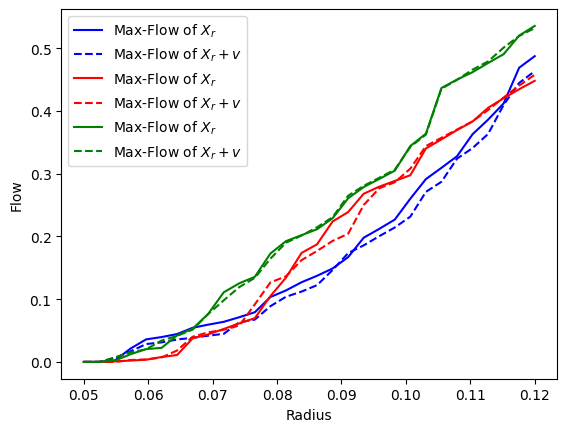

In [7]:
    
f = F[2]
g = G[2]
plt.plot(R[2],f,c=colors[0], label='Max-Flow of $X_r$')
plt.plot(R[2],g,c=colors[0],linestyle='dashed', label='Max-Flow of $X_r+v$')


f = F[4]
g = G[4]
plt.plot(R[3],f,c=colors[1], label='Max-Flow of $X_r$')
plt.plot(R[3],g,c=colors[1],linestyle='dashed', label='Max-Flow of $X_r+v$')


f = F[12]
g = G[12]
plt.plot(R[12],f,c=colors[2], label='Max-Flow of $X_r$')
plt.plot(R[12],g,c=colors[2],linestyle='dashed', label='Max-Flow of $X_r+v$')

plt.xlabel('Radius')
plt.ylabel('Flow')

plt.legend()
plt.show()

In [17]:
SUP_r = np.zeros((len(F),len(F[0])))
SUP = []

for j in range(len(F)):
    
    f = F[j]
    g = G[j]
                                                                                                                                                                                                                                                                                                  
    SUP_r[j,:] = np.abs(f-g)

In [18]:
# We compute the interquartile range (IQR) of the differences between the source target max-flow 
# computed with or without the translation factor

q75, q25 = np.percentile(SUP_r, [75 ,25], axis=0)
err = q75- q25

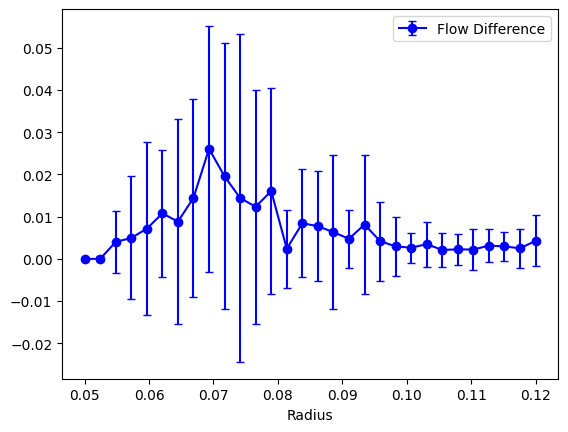

In [20]:
# We plot IQR as bars across the median 

plt.xlabel('Radius')
                                       
plt.errorbar(R[j],np.median(SUP_r,axis=0),yerr=err,c=colors[0],fmt='-o',capsize=3, label='Flow Difference')
plt.legend()    